# 概要
 torchvision.transforms.v2を使用して、BBOXがある場合でのデータ拡張を行うサンプルプログラム

参考サイト
https://tech.aru-zakki.com/torchvision-transforms-v2/

In [1897]:
# パッケージのインポート
from PIL import Image
import torch
import torchvision.transforms.v2 as transforms
from torchvision.io import read_image, ImageReadMode

In [1898]:
# コピペ

# from https://github.com/pytorch/vision/blob/main/gallery/transforms/helpers.py
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [1899]:
# データ拡張の設定
sample_transforms = transforms.Compose([
    transforms.ToImage(),

    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=(600, 600), antialias=True),
    transforms.RandomPerspective(),

    transforms.ToDtype(torch.float32, scale=True)
])

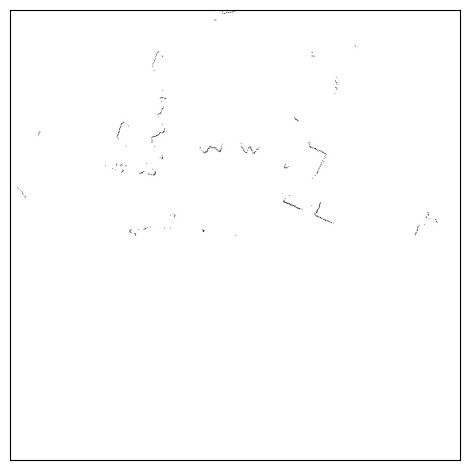

In [1900]:
# 画像の読み込み
img = read_image('images/laser_img_0.jpg', ImageReadMode.RGB)
plot([img])

In [1901]:
# bboxの読み込み(yoloのlabelフォーマットについて：https://qiita.com/yarakigit/items/4d4044bc2740cecba92a)

yolo_format = []

with open('labels/laser_img_0.txt') as f:

    # 情報をすべて少数にして子リストに格納する
    for bbox in f.read().split('\n'):
        yolo_format.append([float(i) for i in bbox.split(' ') if i != ''])

    # for文が一回多いので空のリストを削除
    for index in range(len(yolo_format)):
        if not yolo_format[index]:
            del yolo_format[index]

    # 0番目はクラス番号なので削除
    for index in range(len(yolo_format)):
        del yolo_format[index][0]

    # 各座標をピクセル値に変換する
    px_list = []
    for child in yolo_format:
        bbox_px = list(map(lambda x: x*700, child))
        px_list.append(bbox_px)

    # torchvitionのxmin, ymin, xmax, ymaxに合わせる
    boxes_list = []
    for child in px_list:
        cx = child[0]
        cy = child[1]
        w = child[2]
        h = child[3]

        xmin = cx - (w/2)
        ymin = cy - (h/2)
        xmax = cx + (w/2)
        ymax = cy + (h/2)
        
        boxes_list.append([xmin, ymin, xmax, ymax])





print(yolo_format)  # 確認用
print(boxes_list)   # 使うのはこっち

[[0.532143, 0.309286, 0.064286, 0.047143], [0.447857, 0.309286, 0.072857, 0.038571]]
[[350.00000000000006, 200.00015000000002, 395.0002, 233.00025], [287.99995, 203.00035, 338.99985000000004, 230.00005000000002]]


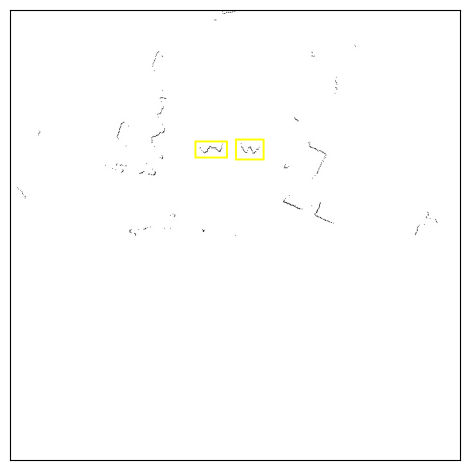

In [1902]:
# bboxと画像の確認

boxes = tv_tensors.BoundingBoxes(
    boxes_list,
    format=tv_tensors.BoundingBoxFormat.XYXY,
    canvas_size=img.shape[-2:]
)

plot([(img, boxes)])

BoundingBoxes([[389.3008, 250.4519, 439.4619, 295.2602],
               [320.2904, 254.6560, 377.1177, 291.3524]], format=BoundingBoxFormat.XYXY, canvas_size=(600, 600))


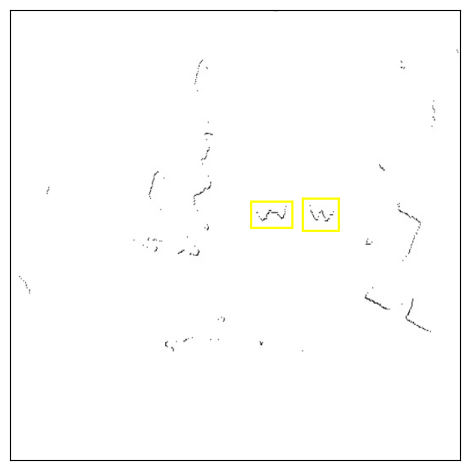

In [1903]:
# 画像変換

img_ts, boxes_ts = sample_transforms(img, boxes)

print(boxes_ts)  # bboxの出力

plot([(img_ts, boxes_ts)])